In [1]:
#Import stuff
import matplotlib.pyplot as plt
import numpy as np
from subprocess import Popen, PIPE
import shlex

from utils import read_opt_file, write_input_file
from sample_gen import sample_sensors

from skopt import Optimizer, expected_minimum, dump


In [2]:
#Load optimization parameters + parameters that will be needed to bulid the input file to the eig code
#Needed for input files: nlpts, ndata, lat_range, long_range, depth_range, sensors
#Assume we are doing sequential greedy sensor placement
#Opt parameters: sensor_lat_range, sensor_long_range, #random initial trial points, #total number of trials
#                sensor type and accuracy, optimization criteria (e.g. UCB, EI)
#Also need info for how to run mpi and how many sensors to place

nopt_random, nopt_total, sensor_lat_range, sensor_long_range, sensor_params, opt_type, nlpts_data, nlpts_space, ndata, lat_range, long_range, depth_range, sensors, mpirunstring, nsensor_place = read_opt_file('inputs_opt.dat')

In [3]:
for isamp in range(0,nsensor_place):

    #Randomly selection the random trial points (right now this is going to be the same every isamp stage)
    #becuase we are intializing the psuedo random seed the same each time.
    sensor_loc_random = sample_sensors(sensor_lat_range,sensor_long_range, nopt_random,nlpts_data+nlpts_space)

    #For each trial point:
    #     Write the input ifile with the sensor info under consideration
    #     run the eig calculator
    #     read and store eig val + eig std

    eigdata = np.zeros([nopt_random,3])
    for inc in range(0,nopt_random):
        print(str(sensors.shape[0]+1) + ' '+ str(inc))
        #write temp input file
        fname = 'input_runner.dat'
        sloc_trial = sensor_loc_random[inc,:]
        write_input_file(fname, nlpts_data, nlpts_space, ndata, lat_range, long_range, depth_range, sloc_trial, sensor_params, sensors)

        #run my MPI
        process = Popen(shlex.split(mpirunstring + " python3 eig_calc.py input_runner.dat outputs.npz 0"), stdout=PIPE, stderr=PIPE, shell=False)
        stdout, stderr = process.communicate()
        outputdata = np.array([float(item) for item in (stdout.decode("utf-8").rstrip("\n")).split()])
        eigdata[inc,:] = outputdata
        
    #Initialize the optimizer not it minimizes
    #0 -> EI    
    if opt_type == 0:
        opt = Optimizer([(sensor_lat_range[0],sensor_lat_range[1]),(sensor_long_range[0],sensor_long_range[1])], "GP", n_initial_points=0,
                    acq_optimizer="lbfgs", acq_func="EI")

    opt.tell(sensor_loc_random.tolist(),(-1.0*eigdata[:,0]).tolist())
    
    eigdata_full = np.zeros([nopt_total,3])
    eigdata_full[0:nopt_random,:] = eigdata

    #Iterage
    for inc in range(nopt_random,nopt_total):
        print(str(sensors.shape[0]+1) + ' '+ str(inc)+ " " + str(-1.0*opt.get_result().fun))
        #write temp input file
        fname = 'input_runner.dat'

        #get the test pt
        sloc_trial = np.array(opt.ask())
        write_input_file(fname, nlpts_data, nlpts_space, ndata, lat_range, long_range, depth_range, sloc_trial, sensor_params, sensors)

        #run my MPI
        process = Popen(shlex.split(mpirunstring + " python3 eig_calc.py input_runner.dat outputs.npz 0"), stdout=PIPE, stderr=PIPE, shell=False)
        stdout, stderr = process.communicate()
        outputdata = np.array([float(item) for item in (stdout.decode("utf-8").rstrip("\n")).split()])
        eigdata_full[inc,:] = outputdata

        #update the optimizer
        opt.tell(sloc_trial.tolist(),-1.0*outputdata[0])
        
        #save the optimization results for fun
        dump(opt.get_result, 'result' + str(sensors.shape[0]+1) + '.pkl')
        
    #now find optimial placement
    newsensor, neig = expected_minimum(opt.get_result())
    
    #append sensor to the list of sensors
    sensorvec = np.zeros(sensors.shape[1])
    sensorvec[0:2] = newsensor
    sensorvec[2:] = sensor_params
    
    sensors = np.vstack((sensors,sensorvec))

3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8 0.840922694899
3 9 0.840922694899
3 10 0.840922694899
3 11 0.897441363401
3 12 0.897441363401
3 13 0.897441363401
3 14 0.897441363401
3 15 0.897441363401
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8 1.55627087695
4 9 1.55627087695
4 10 1.55627087695
4 11 1.55627087695
4 12 1.55627087695
4 13 1.56874377009
4 14 1.56874377009
4 15 1.56874377009
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8 2.1331934656
5 9 2.1331934656
5 10 2.1331934656
5 11 2.1331934656
5 12 2.1331934656
5 13 2.1348347104
5 14 2.1348347104
5 15 2.20073793501


In [4]:
sensors

array([[ 4.00000000e+01, -1.11500000e+02,  1.00000000e-01,
         2.00000000e+00,  0.00000000e+00],
       [ 4.10000000e+01, -1.11900000e+02,  1.00000000e-01,
         2.00000000e+00,  0.00000000e+00],
       [ 4.09640041e+01, -1.10905371e+02,  1.00000000e-01,
         2.00000000e+00,  0.00000000e+00],
       [ 4.10746510e+01, -1.10528456e+02,  1.00000000e-01,
         2.00000000e+00,  0.00000000e+00],
       [ 4.11330714e+01, -1.09965957e+02,  1.00000000e-01,
         2.00000000e+00,  0.00000000e+00]])

In [19]:
write_input_file(fname, nlpts_data, nlpts_space, ndata, lat_range, long_range, depth_range, sloc_trial, sensor_params, sensors)

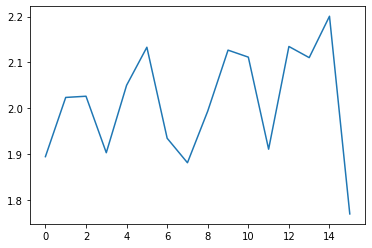

In [5]:
plt.plot(eigdata_full[:,0])
#plt.plot(eigdata_full[:,0]+eigdata_full[:,1])
#plt.plot(eigdata_full[:,0]-eigdata_full[:,1])

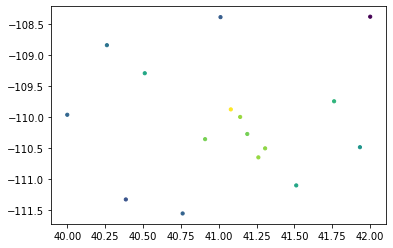

In [6]:
plt.scatter(np.array(opt.Xi)[:,0],np.array(opt.Xi)[:,1],10,eigdata_full[:,0])